In [ ]:
# heatmap of M, D, T markers



In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import UnivariateSpline
from sklearn.cluster import KMeans
import plotly.express as px


In [5]:
q = sc.read_h5ad('../atlas/Atlas_adatas_June2021_Atlas_final_May2021.h5ad')

In [6]:
qobs = pd.read_csv('../DEG_Analysis/EsoAtlas_adatas_june2021_final_obs.csv.gz', index_col=0)

In [7]:
degs = pd.read_csv('../DEG_Analysis/EsoAtlas_DEGs_filtered_by_score_4_11_22.csv', index_col=0)

In [8]:
pbexpr = pd.read_csv('../pseudobulks/pseudobulks_cluster_level/gi_epithelial_pseudobulk.csv', index_col=0)
pbmeta = pd.read_csv('../pseudobulks/pseudobulks_cluster_level/gi_epithelial_metadata.csv', index_col=0)

In [9]:
q.obs = qobs

In [10]:
q.obs.patient.value_counts()

E19    30789
E26    22390
E07    19989
E14    16518
E23    15624
E24    12535
E20    11944
E21    11696
E17    10061
E08     9697
E12     7834
E11     6509
Name: patient, dtype: int64

In [11]:
degs.celltype.value_counts()

gi_epithelial          6841
endothelial            1719
cd8_Tcells              828
neuroendocrine          781
myofibroblasts          722
fibroblasts             651
B_cells                 613
monocytes_macs_DCs      589
cd4_Tcells              170
mast_cells              114
squamous_epithelial      67
NK_cells                 56
naive_T_cells            48
Name: celltype, dtype: int64

In [12]:


def get_full_model_table(preds, pbmeta):

    preds = preds[:, [2,3,1,0,4]]
    dx_list = np.array(['NE','NS','M','D','T'])
    best_call = []
    
    for pi in preds:
        pia = np.array(pi)
        idx = np.argwhere(max(pia) == pia)[0]
        best_call.append(dx_list[idx[0]])    
    
    pred_df = pd.DataFrame(preds, columns=['NE','NS','M','D','T'])
    res_df = pd.concat([pbmeta.reset_index(drop=True), pred_df], axis=1)
    
    res_df['predicted'] = best_call
    
    res_df = res_df.loc[:, ['patient', 'biosample', 'procedure', 'dx', 'predicted', 'cell_counts', 'avg_molecules',  'NE', 'NS', 'M', 'D', 'T'] ]
    
    
    return(res_df)
    

def plot_full_model(preds):

    preds = preds[:, [2,3,1,0,4]]
    
    fig = px.imshow(preds,
                    color_continuous_scale='RdBu_r', 
                    aspect="auto",
                    width=600,
                    height=400,
                   )
    fig.update_layout(
        font_size=8,
        font_family="Courier New",
        font_color="blue",
        title_font_family="Times New Roman",
        title_font_color="red",
        legend_title_font_color="green"
    )
    fig.update_xaxes(side="top")
    fig.show()


def full_model(resDict, scaled_df):
    genes = np.array([])
    preds_mat = []
    dx_list = np.array(['NE','NS','M','D','T'])

    for ri in resDict.keys():
        genes = np.concatenate( (genes, resDict[ri]['genes'].values) )

    X = scaled_df.loc[genes,:]     

    for si in range(0,49):

        idx = [xi for xi in range(0,49)]
        idx.remove(si)

        X1 = X.iloc[:,idx]
        X2 = pd.DataFrame(data=X.iloc[:,si], index=X.index)

        y = pbmeta_gi.dx.values
        y1 = y[idx]

        clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000).fit(X1.T, y1)
        preds = clf.predict_proba(X2.T)
                
        if (len(preds_mat) == 0):
            preds_mat = preds
        else:
            preds_mat = np.vstack( [preds_mat, preds] )

    return(preds_mat)


def sum_gene_overlaps(resDict):
    dx_list = np.array(['NE','NS','M','D','T'])
    sum_overlaps = 0
    for dxi in dx_list:
        for dxj in dx_list[1:]:
            if (dxi != dxj):
                olap = len(set(resDict[dxi]['genes']).intersection(resDict[dxj]['genes']))
                if olap > 0:
                    print('gene overlap: ' + dxi + '  ' + dxj + '  ' + str(olap))
                sum_overlaps += olap

    return(sum_overlaps)


def predict_one_dx(t_idx, coefs, scaled_df, pheno, pbmeta_cs):
    q1 = t_idx[0]
    q2 = t_idx[1]
    idx = np.argwhere( (coefs > q2) | (coefs < q1) )
    idx = [xi[0] for xi in idx]
    markers = scaled_df.iloc[idx,:]
    y = (pbmeta_cs.dx.values == pheno).astype('int')
    X = markers.T
    clf = LogisticRegression().fit(X, y)
    preds = clf.predict_proba(X)
    sns.scatterplot(x=range(0,49), y=preds[:,1], hue=(y))


def plot_thresolds(coefs, t_idx):
    # plot the coefs curve with thresholds
    coefs_sorted = np.array(coefs)
    coefs_sorted.sort()
    k = KMeans(n_clusters=3).fit(coefs_sorted.reshape(-1, 1))
    (q1, q2) = (t_idx[0], t_idx[1])
    g=sns.scatterplot(y=range(0,len(coefs)), x=coefs_sorted, hue=[str(ki) for ki in k.labels_])
    g.axvline(q1, ls='--', linewidth=3, color='red')
    g.axvline(q2, ls='--', linewidth=3, color='red')
    


def get_thresholds(coefs, cl, cr):
    # going to fit a spline and find the 
    # second derivatives to find the 'elbows'
    # then apply a constant until all the signatures
    # are unique to dx's
    t_idx = []
    coefs_sorted = np.array(coefs)
    coefs_sorted.sort()
    n = float(len(coefs))
    x = coefs_sorted 
    y = [xi / n for xi in range(0,int(n))]
    spl = UnivariateSpline(x,y,k=5, s=5)
    spl2 = spl.derivative(n=2)
    xs = np.arange(np.min(x), np.max(x), 0.01)
    # create a list of vals from the derivative
    vals = np.array(spl2(xs)) 
    # and get the max from the left side
    vals_left = vals[xs < 0]
    xidx = np.argwhere(np.max(vals_left) == vals)[0]
    t_idx.append((xs[xidx]-cl)[0])
    # and the min from the right side
    vals_right = vals[xs > 0]
    xidx = np.argwhere(np.min(vals_right) == vals)[0]
    t_idx.append((xs[xidx]+cr)[0])
    # return the thresholds to use.
    return(t_idx)


def get_thresholds_topN(coefs, topN):
    # np.argsort() return
    # array of indices for
    # sorted array
    coefs = np.array(coefs)
    sorted_index_array = np.argsort(coefs)
    # sorted array
    sorted_array = coefs[sorted_index_array]
    # we want 1 largest value
    n = 1
    # we are using negative
    # indexing concept
    # take n largest value
    rslt2 = sorted_array[-topN ]  # high
    rslt1 = sorted_array[ topN ]  # low
    return([rslt1, rslt2])

def score_genes(pheno, scaled_df, pbmeta_cs):
    coefs = []
    for gi in range(0,len(scaled_df)):
        y = (pbmeta_cs.dx.values == pheno).astype('int')
        X = scaled_df.T.iloc[:,gi].values.reshape(-1, 1)
        clf = LogisticRegression(random_state=0).fit(X, y)
        coefs.append(clf.coef_[0][0])
    return(coefs)

def create_gene_signatures(pheno, celltype, degs, pbexpr, pbmeta, cl, cr):
    dx_list = np.array(['NE','NS','M','D','T'])
    # first subset the DEGs to a particular celltype
    degs_cs = degs[degs.celltype == celltype]  ## cs == cell specific
    # then subset the pseudobulk expression to the DEGs
    pbexpr_cs = pbexpr[pbexpr.index.isin(degs_cs.gene)]
    # and remove mixed samples
    pbmeta_cs = pbmeta.loc[pbmeta.dx == "NE"]
    for dxi in dx_list[1:]:
        pbmeta_cs = pbmeta_cs.append( pbmeta.loc[pbmeta.dx == dxi] )
    # reorder the expression to match the metadata
    pbexpr_cs = pbexpr_cs.loc[:, pbmeta_cs.biosample]
    # need to normalize the expression data
    X = RobustScaler(quantile_range=(25, 75)).fit_transform(pbexpr_cs)
    df = pd.DataFrame(data=X, index=pbexpr_cs.index, columns=pbexpr_cs.columns)
    vectors = df.values
    scaled_rows = RobustScaler(quantile_range=(25, 75)).fit_transform(vectors.T).T
    scaled_df = pd.DataFrame(data = scaled_rows, index=df.index, columns = df.columns)
    # score genes per dx
    coefs = score_genes(pheno, scaled_df, pbmeta_cs)
    # Then get our thresholds
    t_idx = get_thresholds(coefs, cl, cr)
    # Then to get the gene list!
    genes = scaled_df.index[ (coefs < t_idx[0])|(coefs > t_idx[1]) ]
    res0 = dict({
        'pheno':pheno,
        'pbexpr_cs':pbexpr_cs,
        'pbmeta_cs':pbmeta_cs,
        'scaled_df':scaled_df,
        'coefs':coefs,
        't_idx':t_idx,
        'genes':genes
        
    })
    return(res0)

def create_gene_signatures_topN(pheno, celltype, degs, pbexpr, pbmeta, topN):
    dx_list = np.array(['NE','NS','M','D','T'])
    # first subset the DEGs to a particular celltype
    degs_cs = degs[degs.celltype == celltype]  ## cs == cell specific
    # then subset the pseudobulk expression to the DEGs
    pbexpr_cs = pbexpr[pbexpr.index.isin(degs_cs.gene)]
    # and remove mixed samples
    pbmeta_cs = pbmeta.loc[pbmeta.dx == "NE"]
    for dxi in dx_list[1:]:
        pbmeta_cs = pbmeta_cs.append( pbmeta.loc[pbmeta.dx == dxi] )
    # reorder the expression to match the metadata
    pbexpr_cs = pbexpr_cs.loc[:, pbmeta_cs.biosample]
    # need to normalize the expression data
    X = RobustScaler(quantile_range=(25, 75)).fit_transform(pbexpr_cs)
    df = pd.DataFrame(data=X, index=pbexpr_cs.index, columns=pbexpr_cs.columns)
    vectors = df.values
    scaled_rows = RobustScaler(quantile_range=(25, 75)).fit_transform(vectors.T).T
    scaled_df = pd.DataFrame(data = scaled_rows, index=df.index, columns = df.columns)
    # score genes per dx
    coefs = score_genes(pheno, scaled_df, pbmeta_cs)
    # Then get our thresholds
    t_idx = get_thresholds_topN(coefs, topN)
    # Then to get the gene list!
    genes = scaled_df.index[ (coefs < t_idx[0])|(coefs > t_idx[1]) ]
    res0 = dict({
        'pheno':pheno,
        'pbexpr_cs':pbexpr_cs,
        'pbmeta_cs':pbmeta_cs,
        'scaled_df':scaled_df,
        'coefs':coefs,
        't_idx':t_idx,
        'genes':genes
        
    })
    return(res0)

In [13]:
### Test ###

resNE = create_gene_signatures_topN('NE', 'gi_epithelial', degs, pbexpr, pbmeta, 101)
resNS = create_gene_signatures_topN('NS', 'gi_epithelial', degs, pbexpr, pbmeta, 101)
resM  = create_gene_signatures_topN('M',  'gi_epithelial', degs, pbexpr, pbmeta, 101)
resD  = create_gene_signatures_topN('D',  'gi_epithelial', degs, pbexpr, pbmeta, 101)
resT  = create_gene_signatures_topN('T',  'gi_epithelial', degs, pbexpr, pbmeta, 101)
resDict = dict({
    'NE':resNE,
    'NS':resNS,
    'M':resM,
    'D':resD,
    'T':resT
})


In [14]:
len(resNS['genes'])

201

In [15]:
sum_gene_overlaps(resDict)

gene overlap: NE  NS  8
gene overlap: NE  M  10
gene overlap: NE  D  10
gene overlap: NE  T  20
gene overlap: NS  M  4
gene overlap: NS  D  2
gene overlap: NS  T  2
gene overlap: M  NS  4
gene overlap: D  NS  2
gene overlap: D  T  6
gene overlap: T  NS  2
gene overlap: T  D  6


76

In [16]:
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier

si = 2
genes = np.array([])
preds_mat = []
dx_list = np.array(['NE','NS','M','D','T'])

for ri in resDict.keys():
    genes = np.concatenate( (genes, resDict[ri]['genes'].values) )

X = scaled_df.loc[genes,:]     

idx = [xi for xi in range(0,49)]
idx.remove(si)

X1 = X.iloc[:,idx]
X2 = pd.DataFrame(data=X.iloc[:,si], index=X.index)

y = pbmeta_gi.dx.values
y1 = y[idx]

clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000).fit(X1.T, y1)
preds = clf.predict_proba(X2.T)

#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.3,
#         max_depth=6, subsample=0.7).fit(X1.T, y1)

#preds = clf.predict_proba(X2.T)

preds

NameError: name 'scaled_df' is not defined

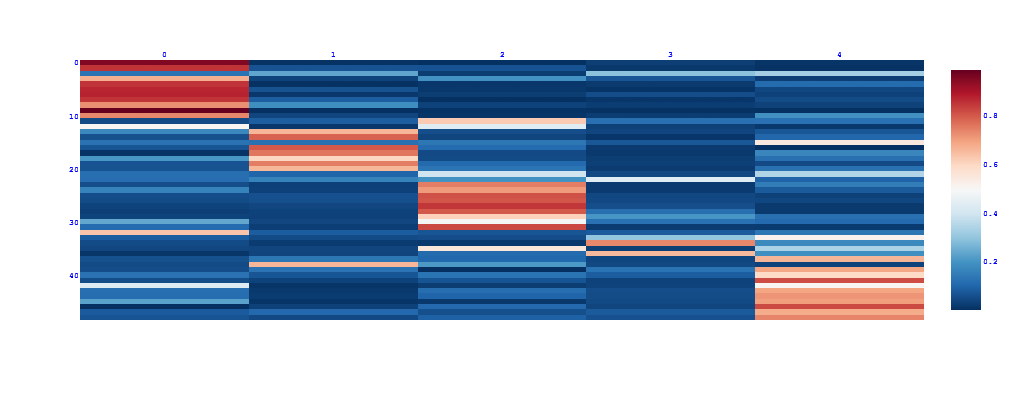

In [737]:
preds = full_model(resDict, scaled_df)

plot_full_model(preds)

In [765]:
pred_df = get_full_model_table(preds, resDict['NE']['pbmeta_cs'])
pred_df.to_csv('gene_sig_tissue_diagnosis_predictions.csv')

In [769]:
len(resDict['NE']['coefs'])

6841

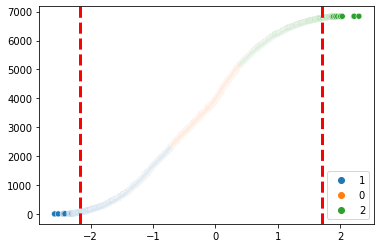

In [721]:
plot_thresolds(resNE['coefs'], resNE['t_idx'])

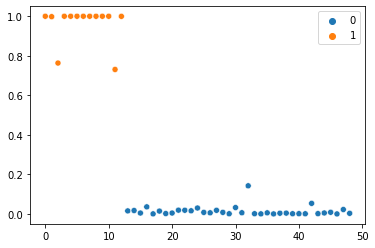

In [722]:
predict_one_dx(resNE['t_idx'], resNE['coefs'], resNE['scaled_df'], "NE", resNE['pbmeta_cs'])


/home/daveg/.local/lib/python3.8/site-packages/seaborn-0.11.1-py3.8.egg/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



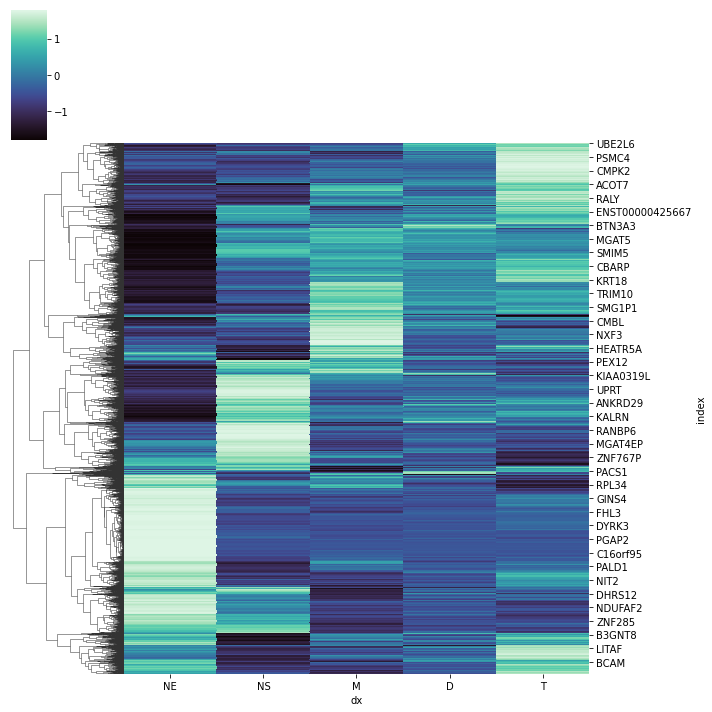

In [738]:
X_raw_T = scaled_df.T
X_raw_T['dx'] = pbmeta_gi.dx.values
X_raw_T_sum = X_raw_T.groupby(['dx'], as_index=True).apply(lambda x: x.sum())
X_raw_T_sum.drop('dx', axis=1, inplace=True)

X_raw_T_sum_T = X_raw_T_sum.T
X_raw_T_sum_T = X_raw_T_sum_T.loc[:,['NE','NS', 'M', 'D', 'T']]

sns.clustermap(data=X_raw_T_sum_T, 
               col_cluster=False, 
               row_cluster=True, 
               z_score=0, 
               standard_scale=None,
               cmap="mako", 
                      )